# Introducción Machine Learning en Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.

## 1. Cargar librerías

In [1]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, auc

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 2. Lectura de datos

In [2]:
dfDiabetes = pd.read_csv("data/diabetic_data.csv")
dfAdmissionSource = pd.read_csv("data/admission_source_id.csv")
dfAdmissionType = pd.read_csv("data/admission_type_id.csv")
dfDischargeDisposition = pd.read_csv("data/discharge_disposition_id.csv")

In [3]:
dfDiabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

### comprobar correcta lectura de los datos

In [4]:
dfDiabetes.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


In [5]:
dfAdmissionSource.head(3)

,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral


In [6]:
dfAdmissionType.head(3)

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective


In [7]:
dfDischargeDisposition.head(3)

,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term h...
2,3,Discharged/transferred to SNF


### juntar todos los datos en el mismo DataFrame

In [8]:
dfDiabetes2 = pd.merge(dfDiabetes, dfAdmissionSource, on = "admission_source_id", how = "left")
dfDiabetes3 = pd.merge(dfDiabetes2, dfAdmissionType, on = "admission_type_id", how = "left")
dfDiabetesFull = pd.merge(dfDiabetes3, dfDischargeDisposition, on = "discharge_disposition_id", how = "left")
dfDiabetesFull.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description_x,description_y,description
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home


### estudiar las dimensiones del dataset

> Bloque con sangría



In [9]:
print("Número de filas: " + str(dfDiabetesFull.shape[0]))
print("Número de columnas: " + str(dfDiabetesFull.shape[1]))

Número de filas: 101766
Número de columnas: 53


In [10]:
dfDiabetesFull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 53 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

## 3. Data Wrangling

### cambiar los nombres de las columnas para que cumplan buenas prácticas

Consideramos buenas prácticas nombrar a las columnas con "ALL_" en minusculas

In [11]:
columnsNameDiabetes = ["encounter_id", "patient_nbr", "race", "gender", "age", "weight", "admission_type_id", "discharge_disposition_id",
                       "admission_source_id", "time_in_hospital", "payer_code", "medical_specialty", "num_lab_procedures", "num_procedures",
                       "num_medications", "number_outpatient", "number_emergency", "number_inpatient", "diag_1", "diag_2", "diag_3",
                       "number_diagnoses", "max_glu_serum", "a1c_result", "metformin", "repaglinide", "nateglinide", "chlorpropamide",
                       "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose",
                       "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide_metformin", "glipizide_metformin",
                       "glimepiride_pioglitazone", "metformin_rosiglitazone", "metformin_pioglitazone", "change", "diabetes_med", "readmitted",
                       "description_x", "description_y", "description"]
dfDiabetesFull.columns = columnsNameDiabetes

### estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

Transformar los id a texto

In [12]:
columnsId = ["encounter_id", "patient_nbr", "admission_type_id", "discharge_disposition_id", "admission_source_id"]

for columnName in columnsId:
  dfDiabetesFull[columnName] = dfDiabetesFull[columnName].apply(str)

Para las variables categorícas se cambia el caracter "?" por "NaN"

In [13]:
#Variables categoricas
dfDiabetesFull.select_dtypes("object").columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
       'max_glu_serum', 'a1c_result', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide_metformin',
       'glipizide_metformin', 'glimepiride_pioglitazone',
       'metformin_rosiglitazone', 'metformin_pioglitazone', 'change',
       'diabetes_med', 'readmitted', 'description_x', 'description_y',
       'description'],
      dtype='object')

In [14]:
#Reemplazamos los valores que deben ser nulos
for columnName in dfDiabetesFull.select_dtypes("object").columns:
    dfDiabetesFull[columnName] = dfDiabetesFull[columnName].replace(["?"], [np.nan])
    dfDiabetesFull[columnName] = dfDiabetesFull[columnName].replace(["None"], [np.nan])

### estudiar si hay registros repetidos

In [15]:
#La primary key es encounter_id, entonces
dfDiabetesFull[["encounter_id"]].duplicated().any()

False

No existen valores duplicados por la llave

### estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

Definimos las variables numéricas y categóricas (despues se irán eliminando algunas en el camino)

In [16]:
columnsNumeric = ["time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_outpatient", "number_emergency",
                   "number_inpatient", "number_diagnoses"]
columnsString = ["race", "gender", "age", "weight", "payer_code", "medical_specialty", "diag_1", "diag_2", "diag_3",
                   "max_glu_serum", "a1c_result", "metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide",
                   "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide",
                   "examide", "citoglipton", "insulin", "glyburide_metformin", "glipizide_metformin", "glimepiride_pioglitazone", "metformin_rosiglitazone",
                   "metformin_pioglitazone", "change", "diabetes_med", "description_x", "description_y", "description"]
columnTarget = "target"

Estudiamos las variables numéricas con la varianza, a varianza más cerca de 0, dicha varianza no aporta al modelo.

In [17]:
dfDiabetesFull[columnsNumeric].var().sort_values(ascending = False)

num_lab_procedures    387.080530
num_medications        66.057332
time_in_hospital        8.910868
number_diagnoses        3.738810
num_procedures          2.909777
number_outpatient       1.605961
number_inpatient        1.594824
number_emergency        0.865779
dtype: float64

La variable que tiene varianza más pequeña es "number_emergency"  
Realizamos un analisis de frecuencia para ver donde se acumula

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000194E0DA88D0>,
      dtype=object)

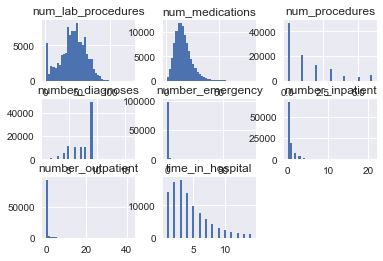

In [18]:
dfDiabetesFull[columnsNumeric].hist(bins = 40)

A las variables "number_outpatient", "number_emergency" y "number_inpatient" hacemos un analisis de frecuencia

In [19]:
for columnName in ["number_outpatient", "number_emergency", "number_inpatient"]:
  print(dfDiabetesFull.fillna("--NULL").groupby(columnName)[columnName].count() / dfDiabetesFull.shape[0] * 100)
  print("\n")

number_outpatient
0     83.551481
1      8.398679
2      3.531631
3      2.006564
4      1.079928
5      0.523751
6      0.297742
7      0.152310
8      0.096299
9      0.081560
10     0.056011
11     0.041271
12     0.029479
13     0.030462
14     0.027514
15     0.019653
16     0.014740
17     0.007861
18     0.004913
19     0.002948
20     0.006879
21     0.006879
22     0.004913
23     0.001965
24     0.002948
25     0.001965
26     0.001965
27     0.002948
28     0.000983
29     0.001965
33     0.001965
34     0.000983
35     0.001965
36     0.001965
37     0.000983
38     0.000983
39     0.000983
40     0.000983
42     0.000983
Name: number_outpatient, dtype: float64


number_emergency
0     88.814535
1      7.543777
2      2.006564
3      0.712419
4      0.367510
5      0.188668
6      0.092369
7      0.071733
8      0.049132
9      0.032427
10     0.033410
11     0.022601
12     0.009826
13     0.011792
14     0.002948
15     0.002948
16     0.004913
18     0.004913
19     0.00

Observamos que se acumulan en 0 pero no en un 90% (no en la gran mayoria), lo tendremos en cuenta en la exploración de datos para descartarlas de ser necesario con más evidencia (mean encoding)

#### Para las variables categoricas vemos sus distribuciones

In [20]:
for columnName in columnsString:
  print(dfDiabetesFull.fillna("--NULL").groupby(columnName)[columnName].count().sort_values(ascending = False) / dfDiabetesFull.shape[0] * 100)
  print("\n")

race
Caucasian          74.778413
AfricanAmerican    18.876639
--NULL              2.233555
Hispanic            2.001651
Other               1.479866
Asian               0.629876
Name: race, dtype: float64


gender
Female             53.758623
Male               46.238429
Unknown/Invalid     0.002948
Name: gender, dtype: float64


age
[70-80)     25.615628
[60-70)     22.092840
[50-60)     16.956547
[80-90)     16.898571
[40-50)      9.516931
[30-40)      3.709490
[90-100)     2.744532
[20-30)      1.628245
[10-20)      0.679009
[0-10)       0.158206
Name: age, dtype: float64


weight
--NULL       96.858479
[75-100)      1.312816
[50-75)       0.881434
[100-125)     0.614154
[125-150)     0.142484
[25-50)       0.095317
[0-25)        0.047167
[150-175)     0.034393
[175-200)     0.010809
>200          0.002948
Name: weight, dtype: float64


payer_code
--NULL    39.557416
MC        31.876069
HM         6.165124
SP         4.920111
BC         4.574219
MD         3.470707
CP         2.489

repaglinide
No        98.487707
Steady     1.359983
Up         0.108091
Down       0.044219
Name: repaglinide, dtype: float64


nateglinide
No        99.309200
Steady     0.656408
Up         0.023584
Down       0.010809
Name: nateglinide, dtype: float64


chlorpropamide
No        99.915492
Steady     0.077629
Up         0.005896
Down       0.000983
Name: chlorpropamide, dtype: float64


glimepiride
No        94.899082
Steady     4.588959
Up         0.321325
Down       0.190633
Name: glimepiride, dtype: float64


acetohexamide
No        99.999017
Steady     0.000983
Name: acetohexamide, dtype: float64


glipizide
No        87.534147
Steady    11.158933
Up         0.756638
Down       0.550282
Name: glipizide, dtype: float64


glyburide
No        89.534815
Steady     9.113063
Up         0.797909
Down       0.554213
Name: glyburide, dtype: float64


tolbutamide
No        99.977399
Steady     0.022601
Name: tolbutamide, dtype: float64


pioglitazone
No        92.799167
Steady     6.854942
U

Consideramos que si se acumula mayor o igual del 90% en su distribución la variable no aporta  
Agregamos a la lista "columnsStringDrop" aquellas donde se acumule más del 90%

In [21]:
limite = 0.9
columnsStringDrop = []
for columnName in columnsString:
  tmp = dfDiabetesFull.fillna("NULL").groupby(columnName)[columnName].count() / dfDiabetesFull.shape[0]
  for value in tmp:
    if value >= limite:
      columnsStringDrop.append(columnName)
      break

columnsString = list(set(columnsString) - set(columnsStringDrop))
print("variables donde se acumula en un solo rango más del 90% de población (incluyendo nulos): " + str(columnsStringDrop))
print("Variables categoricas: " + str(columnsString))

variables donde se acumula en un solo rango más del 90% de población (incluyendo nulos): ['weight', 'max_glu_serum', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide_metformin', 'glipizide_metformin', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 'metformin_pioglitazone']
Variables categoricas: ['gender', 'a1c_result', 'description_y', 'glyburide', 'metformin', 'age', 'diag_2', 'glipizide', 'diag_3', 'insulin', 'payer_code', 'description_x', 'diabetes_med', 'medical_specialty', 'description', 'race', 'diag_1', 'change']


In [22]:
dfDiabetesFull["gender"] = dfDiabetesFull["gender"].replace("Unknown/Invalid", np.nan)

In [23]:
for columnName in columnsString:
  dfDiabetesFull[columnsString] = dfDiabetesFull[columnsString].fillna("NONE")

Para la variable gender reemplazamos el valor undefined por NULL

Graficamos con un diagrama de barras cada variable categoirica sin considerar las que tienen acumulación >= 90% en un rango

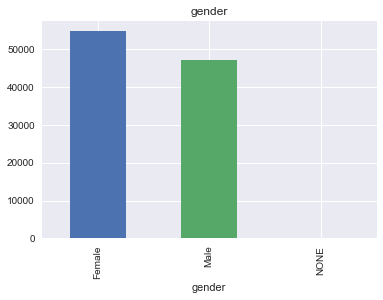

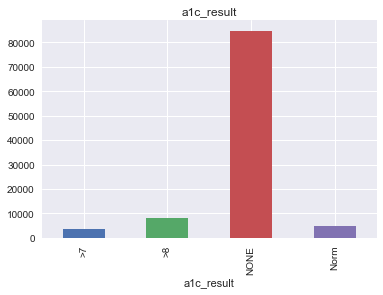

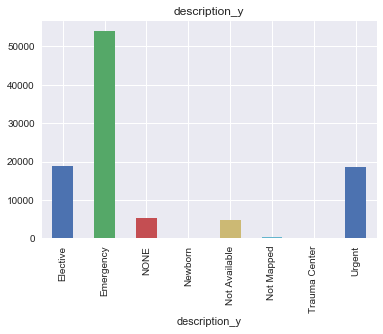

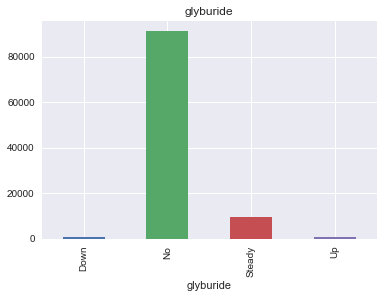

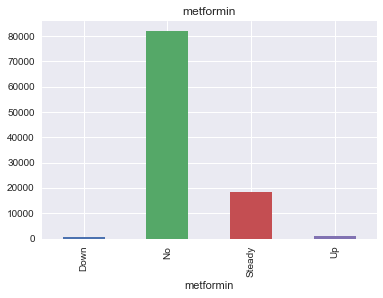

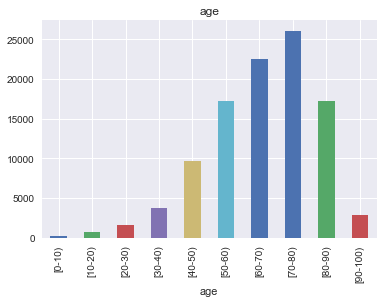

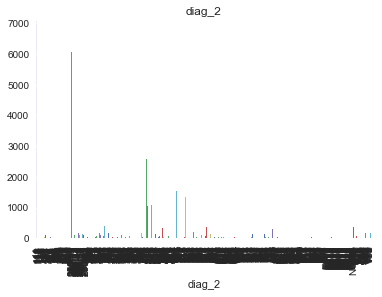

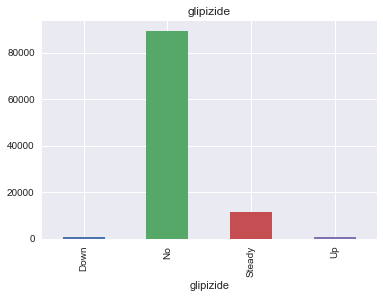

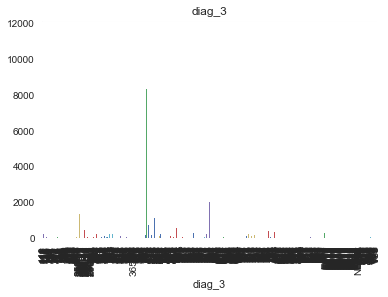

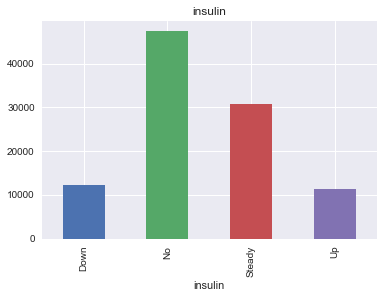

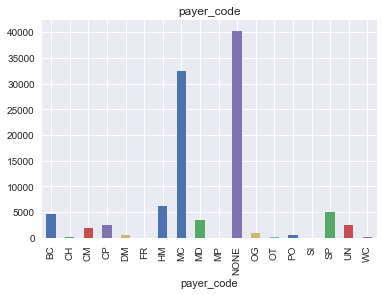

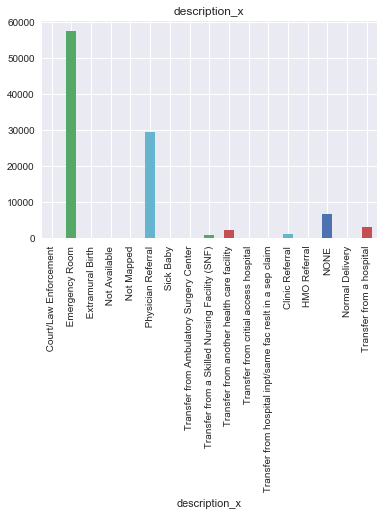

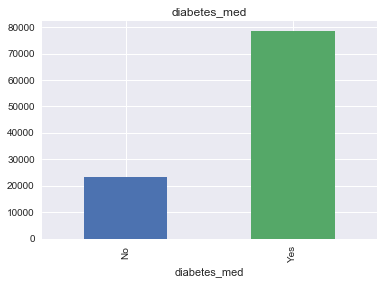

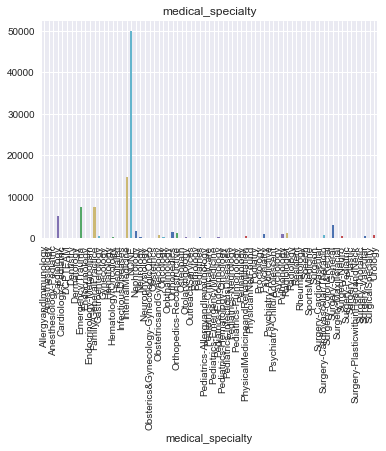

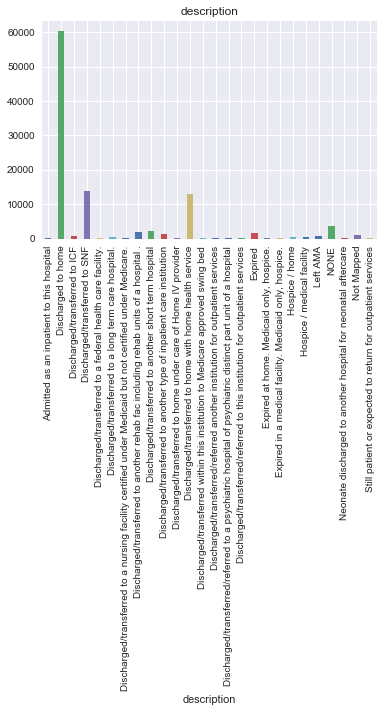

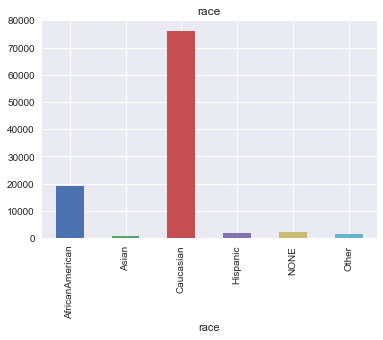

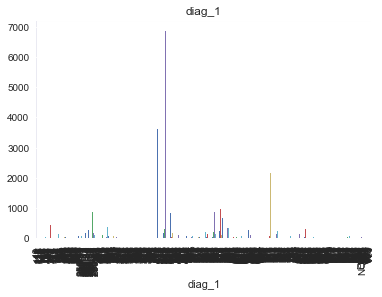

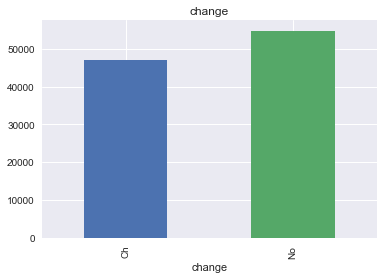

In [24]:
for columnName in columnsString:
  plt.title(columnName)
  dfDiabetesFull.groupby(columnName)[columnName].count().plot(kind = "bar")
  plt.show()

Se observa que las variables diag_1, diag_2 y diag_3 son en su mayoria numéricas, revisamos el porcentaje de numéricas, no numericas y nulos.

In [25]:
def changeType(x):
  try:
    a = float(x)
    if(np.isnan(a)):
      return -1
    else:
      return 1
  except:
    return 0
  
def diagToNumber(x):
  try:
    a = float(x)
    if(np.isnan(a)):
      return float("nan")
    else:
      return a
  except:
    return float("nan")

In [26]:
for columnName in ["diag_1", "diag_2", "diag_3"]:
  numNumeric = dfDiabetesFull[dfDiabetesFull[columnName].apply(changeType) == 1].shape[0]
  numString = dfDiabetesFull[dfDiabetesFull[columnName].apply(changeType) == 0].shape[0]
  numNull = dfDiabetesFull[dfDiabetesFull[columnName].apply(changeType) == -1].shape[0]
  print(columnName)
  print("Numeros: " + str(np.round(numNumeric / dfDiabetesFull.shape[0] * 100, 2)) + "%")
  print("String: " + str(np.round(numString / dfDiabetesFull.shape[0] * 100, 2)) + "%")
  print("Nulos: " + str(np.round(numNull / dfDiabetesFull.shape[0] * 100, 2)) + "%")
  print("\n")

diag_1
Numeros: 98.36%
String: 1.64%
Nulos: 0.0%


diag_2
Numeros: 97.16%
String: 2.84%
Nulos: 0.0%


diag_3
Numeros: 93.63%
String: 6.37%
Nulos: 0.0%




Todos los numéricos son mayores a 90%, tomamos estos para transformar a numéricas estas variables

In [27]:
for columnName in ["diag_1", "diag_2", "diag_3"]:
  dfDiabetesFull[columnName] = dfDiabetesFull[columnName].apply(diagToNumber)
  dfDiabetesFull[columnName] = dfDiabetesFull[columnName].apply(float)

In [28]:
columnsNumeric.append("diag_1")
columnsNumeric.append("diag_2")
columnsNumeric.append("diag_3")

Quitamos de las categoricas

In [29]:
columnsString.remove("diag_1")
columnsString.remove("diag_2")
columnsString.remove("diag_3")

In [30]:
print("columnas numéricas: " + str(columnsNumeric))
print("columnas string: " + str(columnsString))

columnas numéricas: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_1', 'diag_2', 'diag_3']
columnas string: ['gender', 'a1c_result', 'description_y', 'glyburide', 'metformin', 'age', 'glipizide', 'insulin', 'payer_code', 'description_x', 'diabetes_med', 'medical_specialty', 'description', 'race', 'change']


Graficamos las variables numéricas

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000194E17DAB38>,
      dtype=object)

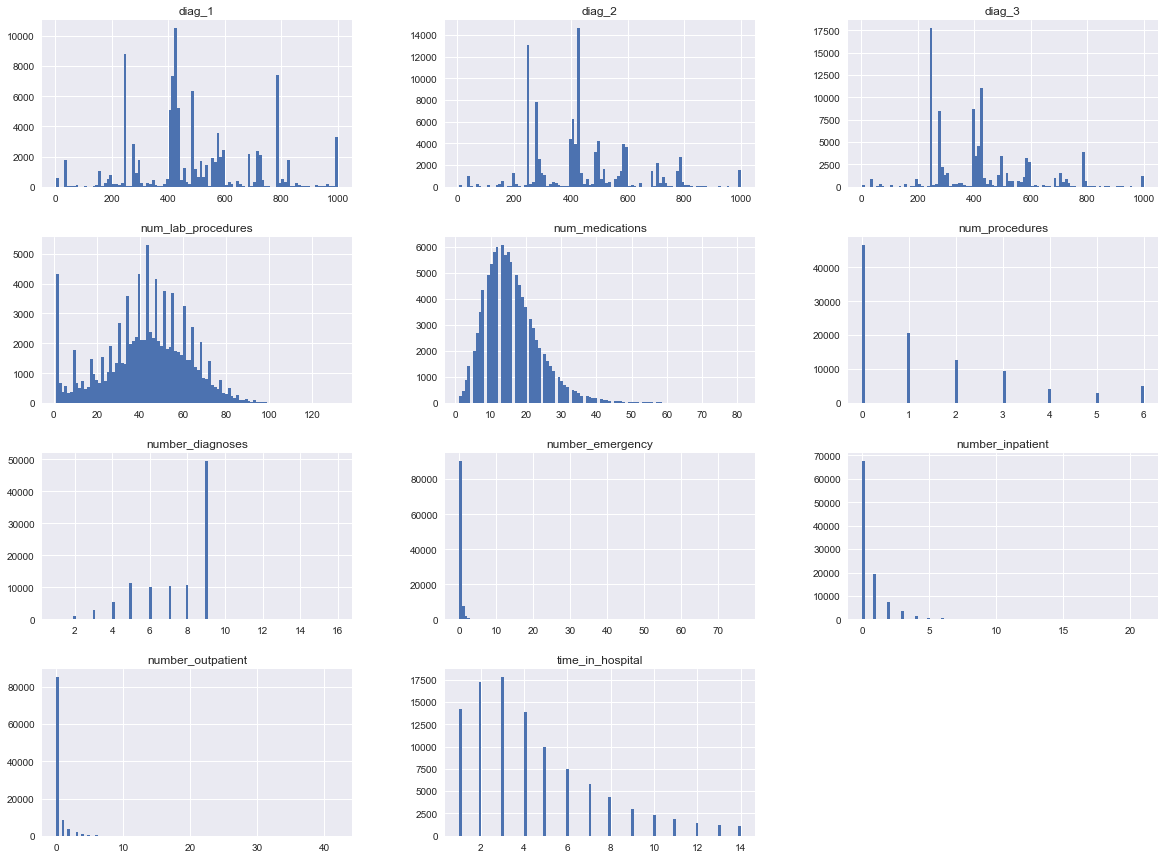

In [31]:
dfDiabetesFull[columnsNumeric].hist(bins = 100, figsize=(20,15))

Columnas categoricas

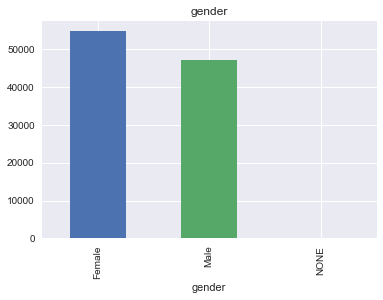

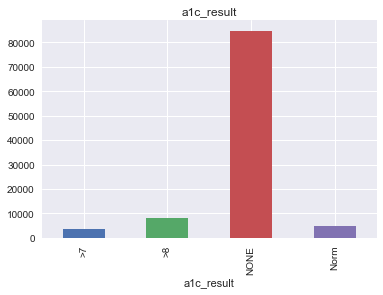

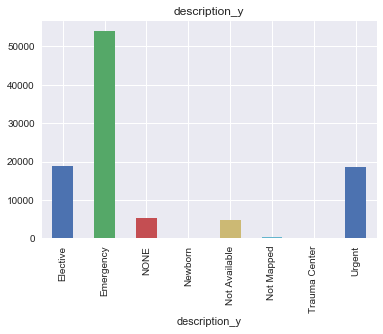

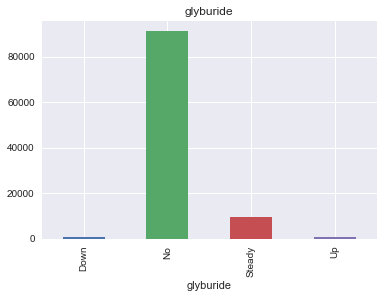

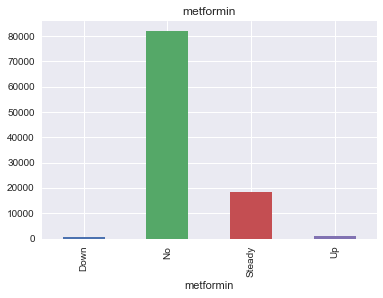

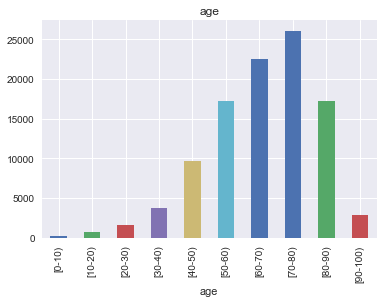

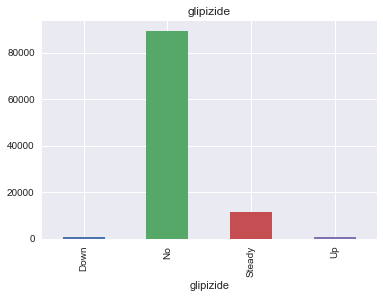

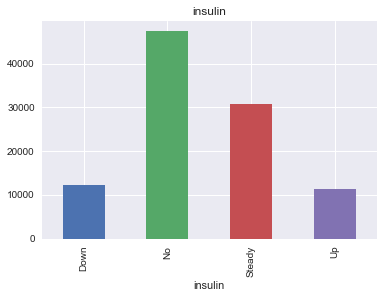

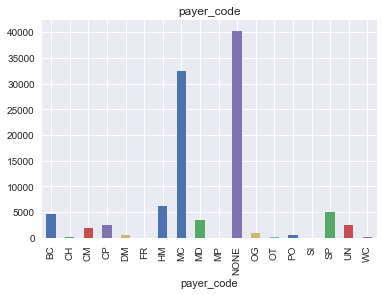

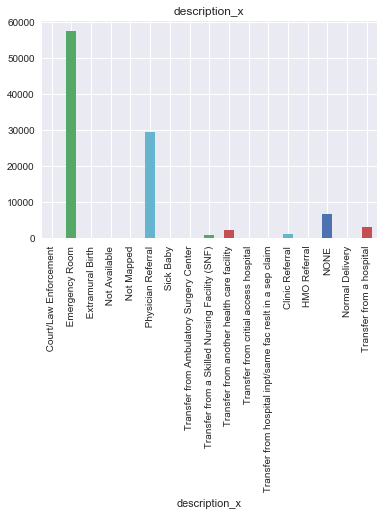

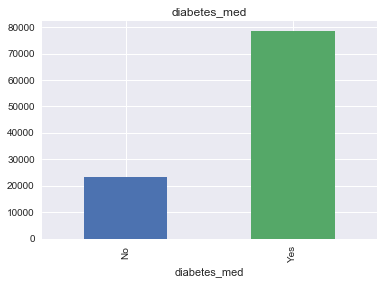

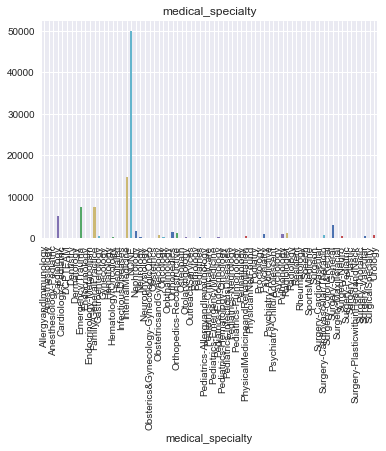

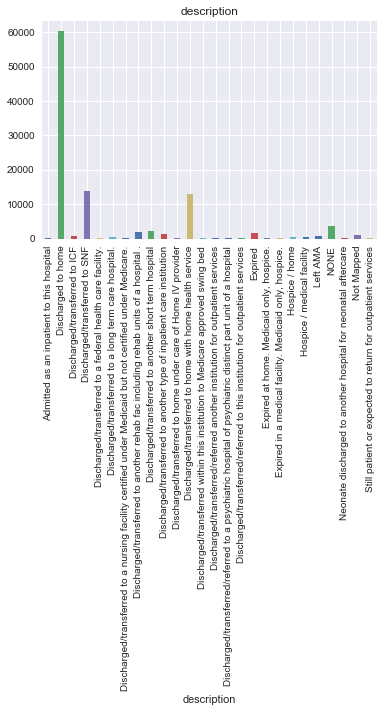

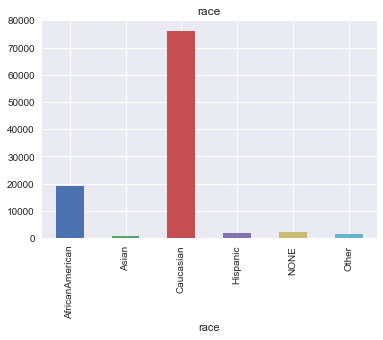

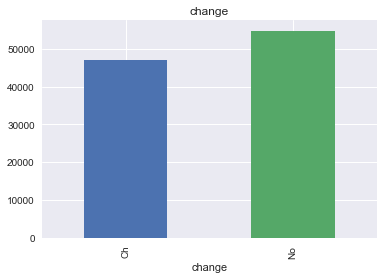

In [32]:
for columnName in columnsString:
  plt.title(columnName)
  dfDiabetesFull.fillna("--NULL").groupby(columnName)[columnName].count().plot(kind = "bar")
  plt.show()

### estudiar los nulos en el dataset

De las districuciones anteriores tenemos ya una idea del impacto de los nulos, repasando:

In [33]:
#Porcentaje y número de nulos por variables
numTotal = dfDiabetesFull.shape[0]
for columnName in list(set(columnsString).union(set(columnsNumeric))):
  numNull = dfDiabetesFull[dfDiabetesFull[columnName].isnull()].shape[0]
  if numNull > 0:
    print(columnName)
    print("Número de valores null: " + str(numNull))
    print("Porcentaje: " + str(np.round(numNull * 100 / numTotal, 2)) + "%")
    print("\n")

diag_2
Número de valores null: 2894
Porcentaje: 2.84%


diag_3
Número de valores null: 6481
Porcentaje: 6.37%


diag_1
Número de valores null: 1666
Porcentaje: 1.64%




Eliminamos las vriables con más de 50% de nulos

In [34]:
#Eliminamos las variables con más de 50%
columnsModel = list(set(columnsString).union(set(columnsNumeric)))
columnsModel.remove("a1c_result")
columnsString.remove("a1c_result")
print("Variables categoricas: " + str(columnsModel))

Variables categoricas: ['diag_2', 'glipizide', 'number_diagnoses', 'num_medications', 'description_x', 'diabetes_med', 'medical_specialty', 'number_inpatient', 'description', 'time_in_hospital', 'race', 'number_outpatient', 'description_y', 'gender', 'glyburide', 'number_emergency', 'metformin', 'age', 'diag_3', 'num_lab_procedures', 'insulin', 'payer_code', 'num_procedures', 'change', 'diag_1']


Para los demás solo inputo la media

In [35]:
for columnName in columnsNumeric:
  dfDiabetesFull[columnName].fillna(dfDiabetesFull[columnName].mean(), inplace = True)

Para la variable "gender" ignoramos estos 3 valores nulos

In [36]:
dfDiabetesFull = dfDiabetesFull[~dfDiabetesFull["gender"].isnull()]

### 4. Estudiar los outliers

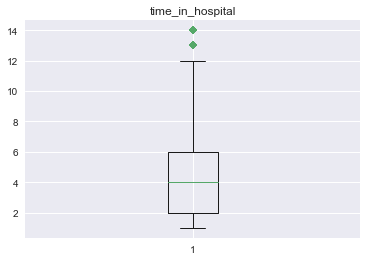

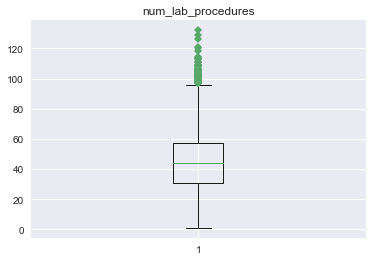

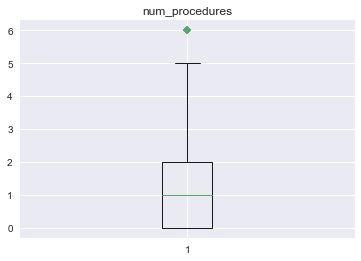

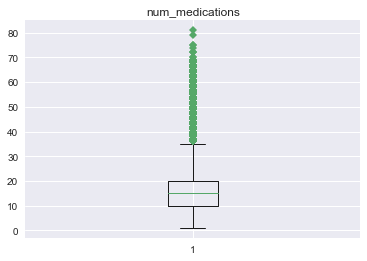

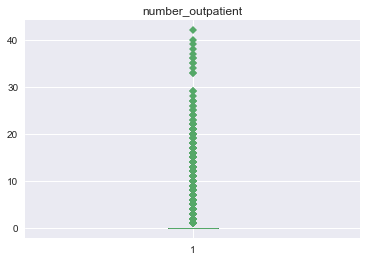

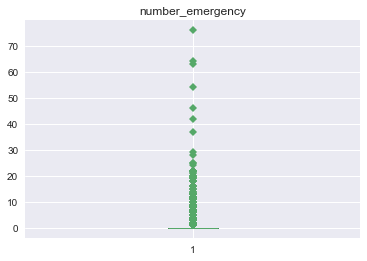

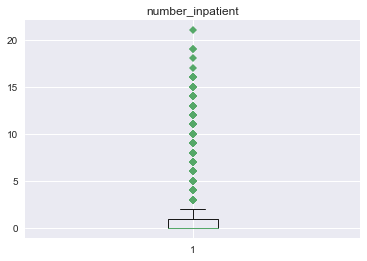

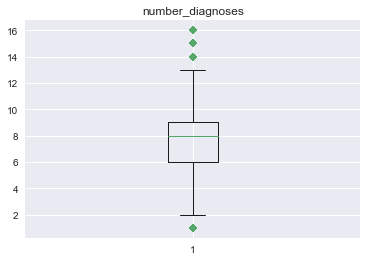

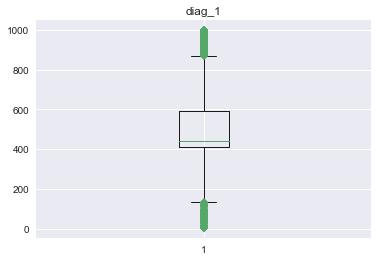

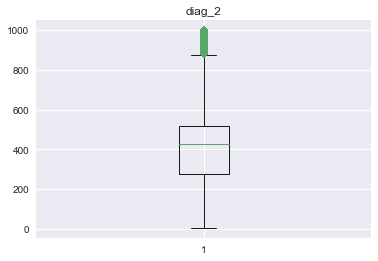

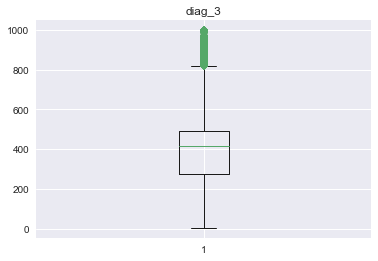

In [37]:
for columnName in dfDiabetesFull[columnsNumeric].columns:
  plt.title(columnName)
  
  plt.boxplot(dfDiabetesFull[columnName], 0, 'gD')
  
  plt.show()

In [38]:
# Función de Identificar Outliers:
def calculateNumOutliars(serie):
  Q01 = serie.quantile(0.25)
  Q03 = serie.quantile(0.75)
  IQR = Q03 - Q01
  a = (serie < (Q01 - 1.5 * IQR)) | (serie > (Q03 + 1.5 * IQR))
  numOutliars = a[a == True].shape[0]
  return numOutliars

In [39]:
#Porcentaje y número de outliars
numTotal = dfDiabetesFull.shape[0]
for columnName in columnsNumeric:
  numOutliars = calculateNumOutliars(dfDiabetesFull[columnName])
  if numOutliars > 0:
    
    numOutliarsLog = calculateNumOutliars(dfDiabetesFull[columnName].apply(np.log))
    
    print(columnName)
    if numOutliarsLog > 0:
      print("Número de valores outliars: " + str(numOutliars))
      print("Porcentaje: " + str(np.round(numOutliars * 100 / numTotal, 2)) + "%")
      print("Número de valores outliars con log: " + str(numOutliarsLog))
      print("Porcentaje con log: " + str(np.round(numOutliarsLog * 100 / numTotal, 2)) + "%")
    else:
      print("****aplicar log")
    
    print("\n")

time_in_hospital
****aplicar log


num_lab_procedures
Número de valores outliars: 143
Porcentaje: 0.14%
Número de valores outliars con log: 9578
Porcentaje con log: 9.41%


num_procedures
****aplicar log


num_medications
Número de valores outliars: 2557
Porcentaje: 2.51%
Número de valores outliars con log: 1823
Porcentaje con log: 1.79%


number_outpatient
****aplicar log


number_emergency
****aplicar log


number_inpatient
****aplicar log


number_diagnoses
Número de valores outliars: 281
Porcentaje: 0.28%
Número de valores outliars con log: 4077
Porcentaje con log: 4.01%


diag_1
Número de valores outliars: 6696
Porcentaje: 6.58%
Número de valores outliars con log: 6096
Porcentaje con log: 5.99%


diag_2
Número de valores outliars: 1795
Porcentaje: 1.76%
Número de valores outliars con log: 1560
Porcentaje con log: 1.53%


diag_3
Número de valores outliars: 1752
Porcentaje: 1.72%
Número de valores outliars con log: 1754
Porcentaje con log: 1.72%




### crear variables dummy en caso que sea conveniente

Para las variables categoricas se ha usado mean encoding

### estudiar que todas las variables ahora sí tengan el formato y contenido adecuado. si todavía no, arreglarlas.

Se verifica que los valores de las variables sean los adecuados

In [40]:
dfDiabetesFull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 53 columns):
encounter_id                101766 non-null object
patient_nbr                 101766 non-null object
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      3197 non-null object
admission_type_id           101766 non-null object
discharge_disposition_id    101766 non-null object
admission_source_id         101766 non-null object
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10

### Antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear
### Definición de Target:

Ya se agregaron las variables necesarias en pasos anteriores.

In [41]:
dfDiabetesFull[columnTarget] = dfDiabetesFull["readmitted"].map({"NO" : 0, ">30" : 1, "<30" : 1}).apply(int)

In [42]:
print("Porcentaje de target: " + str(np.round(dfDiabetesFull[columnTarget].sum() * 100 / dfDiabetesFull.shape[0], 2)) + "%")

Porcentaje de target: 46.09%


# 5. Exploratory Data Analysis

  Para la variable "number_outpatient" agrupamos en solo 3 grupos en los que se distribuye mejor la frecuencia


1.   0: 83.5% --- label 0
2.   1: 8.4% --- label 1
3.   otros: 8.05% --- label 2



In [43]:
funNumberOutpatient = lambda x : 2 if x > 2 else x
    
dfDiabetesFull["number_outpatient"] = dfDiabetesFull["number_outpatient"].apply(funNumberOutpatient)
dfDiabetesFull["number_outpatient"] = dfDiabetesFull["number_outpatient"].apply(str)

Para la variable "number_emergency" agrupamos en solo 3 grupos en los que se distribuye mejor la frecuencia


1.   0: 88.81% --- label 0
2.   1: 7.54% --- label 1
3.   otros: 3.64% --- label 2

In [44]:
funNumberEmergency = lambda x : 2 if x > 2 else x
    
dfDiabetesFull["number_emergency"] = dfDiabetesFull["number_emergency"].apply(funNumberEmergency)
dfDiabetesFull["number_emergency"] = dfDiabetesFull["number_emergency"].apply(str)

Para la variable "number_inpatient" agrupamos en solo 3 grupos en los que se distribuye mejor la frecuencia


1.   0: 66.46% --- label 0
2.   1: 19.18% --- label 1
3.   2: 7.43% --- label 2
4.   3: 3.35% --- label 3
5.   4: 3.47% --- label 4


In [45]:
funNumberInpatient = lambda x : 4 if x > 4 else x
    
dfDiabetesFull["number_inpatient"] = dfDiabetesFull["number_inpatient"].apply(funNumberInpatient)
dfDiabetesFull["number_inpatient"] = dfDiabetesFull["number_inpatient"].apply(str)

Agregamos las variables creadas al ColumnsString

In [46]:
columnsNumeric.remove("number_inpatient")
columnsNumeric.remove("number_emergency")
columnsNumeric.remove("number_outpatient")

columnsString.append("number_inpatient")
columnsString.append("number_emergency")
columnsString.append("number_outpatient")

Ejecutamos mean encoder

In [47]:
#Mean encoder
for columnName in columnsString:
  mapColumn = dfDiabetesFull.groupby(columnName)[columnTarget].mean()
  dfDiabetesFull[columnName + "_number"] = dfDiabetesFull[columnName].map(mapColumn)

In [48]:
columnsToEvaluate = columnsNumeric + [columnName + "_number" for columnName in columnsString]
print("Variables a evaluar: " + str(columnsToEvaluate))

Variables a evaluar: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'diag_1', 'diag_2', 'diag_3', 'gender_number', 'description_y_number', 'glyburide_number', 'metformin_number', 'age_number', 'glipizide_number', 'insulin_number', 'payer_code_number', 'description_x_number', 'diabetes_med_number', 'medical_specialty_number', 'description_number', 'race_number', 'change_number', 'number_inpatient_number', 'number_emergency_number', 'number_outpatient_number']


In [49]:
for columnName in columnsNumeric:
  dfDiabetesFull[columnName].fillna(dfDiabetesFull[columnName].mean(), inplace = True)

In [50]:
dfDiabetesFull.head(4)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,payer_code_number,description_x_number,diabetes_med_number,medical_specialty_number,description_number,race_number,change_number,number_inpatient_number,number_emergency_number,number_outpatient_number
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,0.458441,0.431930,0.404777,0.150943,0.473205,0.469336,0.439631,0.384948,0.438943,0.436508
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,0.458441,0.493738,0.477636,0.480430,0.450227,0.469336,0.485631,0.384948,0.438943,0.436508
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,0.458441,0.493738,0.477636,0.480430,0.450227,0.457522,0.439631,0.547615,0.438943,0.596069
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,0.458441,0.493738,0.477636,0.480430,0.450227,0.469336,0.485631,0.384948,0.438943,0.436508


In [51]:
#Evaluamos la varianza de las variables nuevas categoricas
dfDiabetesFull[[x + "_number" for x in columnsString]].var()

gender_number               0.000087
description_y_number        0.000939
glyburide_number            0.000011
metformin_number            0.000205
age_number                  0.000602
glipizide_number            0.000111
insulin_number              0.001165
payer_code_number           0.001168
description_x_number        0.002645
diabetes_med_number         0.000940
medical_specialty_number    0.002794
description_number          0.005857
race_number                 0.000681
change_number               0.000526
number_inpatient_number     0.013744
number_emergency_number     0.004233
number_outpatient_number    0.003038
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000194E2CF62E8>,
      dtype=object)

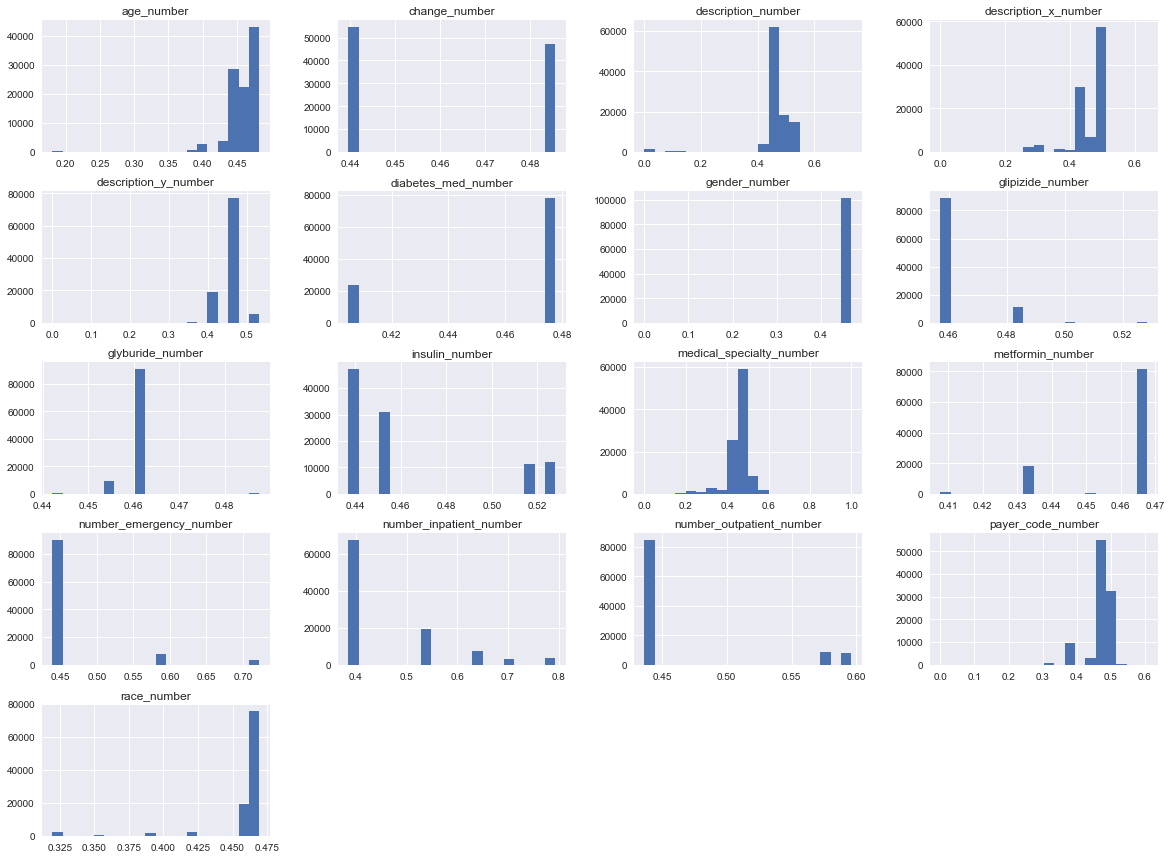

In [52]:
dfDiabetesFull[[x + "_number" for x in columnsString]].hist(bins = 20, figsize=(20,15))

In [53]:
#Eliminamos gender_number
columnsToEvaluate.remove("gender_number")

## 6. Estandarizamos

In [54]:
# Creamos el objeto para escalar
#scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler = preprocessing.StandardScaler()

# Lo aplicamos
for columnName in columnsNumeric:
  dfDiabetesFull[columnName] = scaler.fit_transform(dfDiabetesFull[columnName].values.reshape(-1, 1))

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConv

In [55]:
dfDiabetesFull[columnsNumeric].head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,diag_1,diag_2,diag_3
0,-1.137649,-0.106517,-0.785398,-1.848268,-3.321596,-1.184073,6.769429e-14,5.201202e-14
1,-0.467653,0.808384,-0.785398,0.243390,0.815784,-1.061302,-1.069901e+00,-9.510184e-01
2,-0.802651,-1.631351,2.145781,-0.371804,-0.735733,0.753197,-1.069958e+00,5.201202e-14
3,-0.802651,0.045967,-0.199162,-0.002688,-0.218561,-2.368522,-1.067519e+00,-8.846576e-02
4,-1.137649,0.401761,-0.785398,-0.986997,-1.252906,-1.446639,-1.597352e+00,-9.801587e-01


## 7. Asignación de Muestra Train - Test

Selecionamos una muestra

In [56]:
X = dfDiabetesFull[columnsToEvaluate].values
y = dfDiabetesFull[[columnTarget]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

Aplicamos mean encoder a las variables categoricas

### crear la matriz de correlación

In [57]:
pdX_train = pd.DataFrame(X_train, columns = columnsToEvaluate)
pdy_train = pd.DataFrame(y_train, columns = ["target"])
pdX_test = pd.DataFrame(X_test, columns = columnsToEvaluate)
pdy_test = pd.DataFrame(y_test, columns = ["target"])

### pintar la matriz de correlación

In [58]:
pdX_train.corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,diag_1,diag_2,diag_3,description_y_number,glyburide_number,...,payer_code_number,description_x_number,diabetes_med_number,medical_specialty_number,description_number,race_number,change_number,number_inpatient_number,number_emergency_number,number_outpatient_number
time_in_hospital,1.000000,0.317390,0.189580,0.465542,0.218447,-0.088885,0.072395,0.085505,0.019935,-0.006601,...,0.056450,-0.041758,0.063685,0.043720,0.075939,0.009356,0.109697,0.090020,-0.008169,-0.019463
num_lab_procedures,0.317390,1.000000,0.054441,0.267431,0.153616,-0.082610,0.010253,0.030304,0.223676,0.007425,...,0.021360,0.110319,0.033423,0.064674,-0.029040,-0.007776,0.062106,0.043573,0.004460,-0.030481
num_procedures,0.189580,0.054441,1.000000,0.381687,0.074793,-0.009251,0.061101,0.049142,-0.167232,0.000192,...,-0.046571,-0.150700,-0.008652,-0.096481,-0.032934,0.010267,0.003168,-0.073386,-0.052784,-0.035912
num_medications,0.465542,0.267431,0.381687,1.000000,0.261420,0.002437,0.076628,0.069168,-0.113417,-0.014740,...,0.036293,-0.049014,0.186806,-0.063955,0.055043,0.033737,0.244196,0.075587,0.026588,0.057331
number_diagnoses,0.218447,0.153616,0.074793,0.261420,1.000000,0.008692,0.150554,0.156958,0.039103,0.019032,...,0.100441,0.163604,0.023707,0.204908,0.035427,0.080154,0.054160,0.133624,0.082356,0.109104
diag_1,-0.088885,-0.082610,-0.009251,0.002437,0.008692,1.000000,-0.001578,-0.018622,-0.023458,-0.007872,...,-0.019682,0.004531,-0.031841,-0.083480,0.068119,0.004507,-0.034478,-0.018780,-0.015473,0.001344
diag_2,0.072395,0.010253,0.061101,0.076628,0.150554,-0.001578,1.000000,0.067390,-0.025854,0.001534,...,0.011613,-0.009434,-0.008095,0.010596,0.026741,0.001914,-0.004004,0.020870,0.004057,0.022457
diag_3,0.085505,0.030304,0.049142,0.069168,0.156958,-0.018622,0.067390,1.000000,-0.013761,0.009821,...,0.012774,0.003225,-0.002689,0.012547,0.017364,0.001027,0.004171,0.020015,0.008937,0.021595
description_y_number,0.019935,0.223676,-0.167232,-0.113417,0.039103,-0.023458,-0.025854,-0.013761,1.000000,0.000345,...,0.029328,0.308829,-0.023719,0.154674,-0.024076,-0.011953,-0.044810,0.039825,0.028589,0.006112
glyburide_number,-0.006601,0.007425,0.000192,-0.014740,0.019032,-0.007872,0.001534,0.009821,0.000345,1.000000,...,-0.001384,0.005209,-0.106080,0.012747,-0.007112,-0.002547,-0.089209,0.025095,0.022333,0.006486


### determinar qué par de variables están correlacionadas

In [59]:
for columnName in columnsToEvaluate:
  dfDiabetesFull_corr = pdX_train.corr()[columnName]
  df_numerical_most_corr = dfDiabetesFull_corr[(abs(dfDiabetesFull_corr) > 0.5) & (abs(dfDiabetesFull_corr) < 1.0)]
  if df_numerical_most_corr.shape[0] > 0:
    print(columnName)
    print(df_numerical_most_corr)
    print("\n")

insulin_number
change_number    0.623341
Name: insulin_number, dtype: float64


diabetes_med_number
change_number    0.506878
Name: diabetes_med_number, dtype: float64


change_number
insulin_number         0.623341
diabetes_med_number    0.506878
Name: change_number, dtype: float64




Obtenemos el valor de significacia de cada variable

### estudiar los pares de variables correlacionadas para quedarse solamente con una del par

In [60]:
pd1 = pdX_train.join(pd.DataFrame(y_train, columns = ["target"]))
print(pd1[["insulin_number", "target"]].corr())
print(pd1[["change_number", "target"]].corr())

                insulin_number    target
insulin_number        1.000000  0.066585
target                0.066585  1.000000
               change_number    target
change_number       1.000000  0.044533
target              0.044533  1.000000


Eliminamos "change_number" y con esto todas las correlaciones se resuelven

In [61]:
columnsToEvaluate.remove("change_number")

# 8. Modelado y Evaluación:

### Estandarizar variables

In [62]:
#Ya está Estandarizado

### 8.0 Random Forest (selección de variables):

In [63]:
rf = RandomForestClassifier(n_estimators = 10, random_state = 3)

# Entrenamiento del modelo
rf.fit(pdX_train[columnsToEvaluate], y_train);

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [64]:
# Extrayendo la importancia de variables:
importances = list(rf.feature_importances_)

In [65]:
# Ubicamos a la importancia y nombre de varoables en una lista
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(columnsToEvaluate, importances)]

# Ordenamos las variables conforme al grado de importancia
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Visualizamos la importancia de las variables:
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: num_lab_procedures             Importance: 0.1
Variable: diag_1                         Importance: 0.09
Variable: diag_2                         Importance: 0.09
Variable: diag_3                         Importance: 0.09
Variable: num_medications                Importance: 0.08
Variable: time_in_hospital               Importance: 0.06
Variable: medical_specialty_number       Importance: 0.05
Variable: description_number             Importance: 0.05
Variable: number_inpatient_number        Importance: 0.05
Variable: num_procedures                 Importance: 0.04
Variable: number_diagnoses               Importance: 0.04
Variable: age_number                     Importance: 0.04
Variable: payer_code_number              Importance: 0.04
Variable: description_y_number           Importance: 0.03
Variable: insulin_number                 Importance: 0.03
Variable: metformin_number               Importance: 0.02
Variable: description_x_number           Importance: 0.02
Variable: race_

### 8.1 Regresión Logística:

In [66]:
# Regresión Logístico:
classifier = LogisticRegression()
classifier.fit(pdX_train[columnsToEvaluate], y_train)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Predicción:

In [67]:
prediction_train = classifier.score(pdX_train[columnsToEvaluate], y_train)
prediction_test = classifier.score(pdX_test[columnsToEvaluate], y_test)

In [68]:
print('--------------------------')
print('    Indicador Training')
print('--------------------------\n')
print("Regresión logística - AUC: " + str(np.round(prediction_train * 100, 1)) + "%")
y_pred = classifier.predict(pdX_train[columnsToEvaluate])
print("Regresión logística - F1: " + str(np.round(f1_score(y_train, y_pred) * 100, 1)) + "%")

print('\n--------------------------')
print('    Indicador Testing')
print('--------------------------\n')
print("Regresión logística - AUC: " + str(np.round(prediction_test * 100, 1)) + "%")
y_pred = classifier.predict(pdX_test[columnsToEvaluate])
print("Regresión logística - F1: " + str(np.round(f1_score(y_test, y_pred) * 100, 1)) + "%")

--------------------------
    Indicador Training
--------------------------

Regresión logística - AUC: 63.3%
Regresión logística - F1: 55.2%

--------------------------
    Indicador Testing
--------------------------

Regresión logística - AUC: 63.6%
Regresión logística - F1: 55.3%


### 8.2 Arboles de Decisiones:

In [69]:
reg = DecisionTreeClassifier(max_depth = 10)
reg.fit(pdX_train[columnsToEvaluate], y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [70]:
prediction2_train = reg.score(pdX_train[columnsToEvaluate], y_train)
prediction2_test = reg.score(pdX_test[columnsToEvaluate], y_test)

In [71]:
print('\n--------------------------')
print('    Indicador Training')
print('--------------------------\n')
print("Árbol de decisión - AUC: " + str(np.round(prediction2_train * 100, 1)) + "%")
y_pred = reg.predict(pdX_train[columnsToEvaluate])
print("Árbol de decisión - F1: " + str(np.round(f1_score(y_train, y_pred) * 100, 1)) + "%")

print('\n--------------------------')
print('    Indicador Testing')
print('--------------------------\n')
print("Árbol de decisión - AUC: " + str(np.round(prediction2_test * 100, 1)) + "%")
y_pred = reg.predict(pdX_test[columnsToEvaluate])
print("Árbol de decisión - F1: " + str(np.round(f1_score(y_test, y_pred) * 100, 1)) + "%")


--------------------------
    Indicador Training
--------------------------

Árbol de decisión - AUC: 64.8%
Árbol de decisión - F1: 56.2%

--------------------------
    Indicador Testing
--------------------------

Árbol de decisión - AUC: 63.2%
Árbol de decisión - F1: 53.9%


### 8.3 Modelo GBoosting:

In [72]:
clf = GradientBoostingClassifier(n_estimators=200, max_depth = 4, learning_rate = .4)
clf.fit(pdX_train[columnsToEvaluate], pdy_train)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.4, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [73]:
prediction3_train = clf.score(pdX_train[columnsToEvaluate], pdy_train)
prediction3_test = clf.score(pdX_test[columnsToEvaluate], pdy_test)

In [74]:
print('\n--------------------------')
print('    Indicador Training')
print('--------------------------\n')
print("Modelo GBoost - AUC: " + str(np.round(prediction3_train * 100, 1)) + "%")
y_pred = clf.predict(pdX_train[columnsToEvaluate])
print("Modelo GBoost - F1: " + str(np.round(f1_score(y_train, y_pred) * 100, 1)) + "%")

print('\n--------------------------')
print('    Indicador Testing')
print('--------------------------\n')
print("Modelo GBoost - AUC: " + str(np.round(prediction3_test * 100, 1)) + "%")
y_pred = clf.predict(pdX_test[columnsToEvaluate])
print("Modelo GBoost - F1: " + str(np.round(f1_score(y_test, y_pred) * 100, 1)) + "%")


--------------------------
    Indicador Training
--------------------------

Modelo GBoost - AUC: 70.4%
Modelo GBoost - F1: 66.5%

--------------------------
    Indicador Testing
--------------------------

Modelo GBoost - AUC: 65.2%
Modelo GBoost - F1: 60.3%


## 9. Decisión:

De las ejecuciones hechas el mejor indicador sería el GBUST

In [75]:
print("Mejor modelo => GBoost - AUC: " + str(np.round(prediction3_test * 100, 1)) + "%")

Mejor modelo => GBoost - AUC: 65.2%


## 10. Réplica del modelo elegido:

In [76]:
# Luego de la elección del mejor modelo:
prediction = classifier.predict(pdX_train[columnsToEvaluate])

In [77]:
dataBaseFinal = pdX_train[columnsToEvaluate] 
dataBaseFinal['target'] = pd.DataFrame(y_train)
dataBaseFinal['prediction'] = pd.DataFrame(prediction)
dataBaseFinal.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,diag_1,diag_2,diag_3,description_y_number,glyburide_number,...,description_x_number,diabetes_med_number,medical_specialty_number,description_number,race_number,number_inpatient_number,number_emergency_number,number_outpatient_number,target,prediction
0,-0.802651,-0.259000,2.145781,-0.986997,-1.770078,-0.388181,-0.945198,-6.596155e-01,0.532414,0.461522,...,0.431930,0.404777,0.476613,0.473205,0.469336,0.384948,0.438943,0.436508,0,0
1,-0.132655,-1.072245,-0.199162,0.735544,-1.770078,1.167801,-0.213651,-9.801587e-01,0.408448,0.461522,...,0.431930,0.477636,0.341429,0.450227,0.469336,0.384948,0.438943,0.436508,0,0
2,-0.467653,1.011695,2.145781,-0.740920,0.298612,-0.290627,-0.213651,-9.766619e-01,0.408448,0.454604,...,0.493738,0.477636,0.509187,0.498925,0.457522,0.384948,0.438943,0.436508,1,0
3,2.212331,1.723285,2.732016,0.735544,0.815784,0.182508,-0.060536,3.392346e-02,0.472865,0.461522,...,0.493738,0.404777,0.447886,0.450227,0.469336,0.384948,0.438943,0.436508,0,0
4,-1.137649,-0.106517,-0.785398,-1.233074,-1.252906,-1.061302,-0.037853,5.201202e-14,0.472865,0.461522,...,0.269435,0.404777,0.435190,0.450227,0.469336,0.384948,0.438943,0.436508,0,0
